In [ ]:
import os
import torch
from transformers import BertTokenizer, BertModel
from google.colab import drive

In [ ]:
import os
import random
import chardet
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


In [ ]:
import numpy as np # Import numpy

In [ ]:
# Mount Google Drive to access files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define dataset paths
lyrics_directory = '/content/drive/MyDrive/NEUROMATCH DL'
popular_lyrics_dir = os.path.join(lyrics_directory, 'popular_lyrics')
unpopular_lyrics_dir = os.path.join(lyrics_directory, 'unpopular_lyrics')

In [ ]:
import chardet

In [ ]:
# Function to read lyrics from files with a limit on number of files
def read_lyrics(directory, limit=None):
    file_names = os.listdir(directory)
    if limit is not None:
        file_names = random.sample(file_names, limit)
    lyrics = []
    for file_name in file_names:
        file_path = os.path.join(directory, file_name)
        with open(file_path, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            encoding = result['encoding'] if result['encoding'] else 'utf-8'
            lyrics.append(raw_data.decode(encoding, errors='ignore'))  # Ignore errors
    return lyrics


In [ ]:
# Read popular and unpopular lyrics with specified limits
popular_lyrics = read_lyrics(popular_lyrics_dir, limit=200)
unpopular_lyrics = read_lyrics(unpopular_lyrics_dir)

In [ ]:
# Create dataframe
data = {'lyrics': popular_lyrics + unpopular_lyrics,
        'label': [1] * len(popular_lyrics) + [0] * len(unpopular_lyrics)}

df = pd.DataFrame(data)


In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Custom Dataset class
class LyricsDataset(Dataset):
    def __init__(self, lyrics, labels, tokenizer, max_length=128):
        self.lyrics = lyrics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, idx):
        lyric = self.lyrics[idx]
        lines = lyric.split('\n')
        if len(lines) < 2:
            lines.append('')  # Ensure there are at least two lines
        inputs = self.tokenizer(lines[0], lines[1], truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs

In [ ]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Create Dataset objects
train_dataset = LyricsDataset(train_df['lyrics'].tolist(), train_df['label'].tolist(), tokenizer)
test_dataset = LyricsDataset(test_df['lyrics'].tolist(), test_df['label'].tolist(), tokenizer)


In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Define BERT model for embedding extraction
bert_model = BertModel.from_pretrained('bert-base-uncased')


In [ ]:
# Function to extract embeddings
def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())
            labels.append(batch['labels'].cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

In [ ]:

# Extract embeddings for train and test sets
train_embeddings, train_labels = extract_embeddings(train_loader, bert_model)
test_embeddings, test_labels = extract_embeddings(test_loader, bert_model)

In [ ]:
# Define a simple classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Initialize classifier
input_dim = train_embeddings.shape[1]
num_classes = 2
classifier = SimpleClassifier(input_dim, num_classes)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)


In [ ]:
import os
import random
import chardet
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

In [ ]:
# Training function
def train_model(model, train_data, train_labels, criterion, optimizer, epochs=50):
    model.train()
    loss_history = []
    accuracy_history = []
    bleu_scores = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(torch.tensor(train_data, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(train_labels, dtype=torch.long))
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(train_labels, predicted.numpy())

        # Calculate BLEU score (simple implementation)
        references = [[str(label)] for label in train_labels]
        candidates = [str(pred) for pred in predicted.numpy()]
        bleu_score = sentence_bleu(references, candidates)

        # Record history
        loss_history.append(loss.item())
        accuracy_history.append(accuracy)
        bleu_scores.append(bleu_score)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, BLEU: {bleu_score:.4f}')

    return loss_history, accuracy_history, bleu_scores

# Train classifier and get history
loss_history, accuracy_history, bleu_scores = train_model(classifier, train_embeddings, train_labels, criterion, optimizer)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch [1/50], Loss: 0.6956, Accuracy: 0.4856, BLEU: 0.0000
Epoch [2/50], Loss: 0.6801, Accuracy: 0.5591, BLEU: 0.0000
Epoch [3/50], Loss: 0.6672, Accuracy: 0.5974, BLEU: 0.0000
Epoch [4/50], Loss: 0.6548, Accuracy: 0.6230, BLEU: 0.0000
Epoch [5/50], Loss: 0.6432, Accuracy: 0.6645, BLEU: 0.0000
Epoch [6/50], Loss: 0.6329, Accuracy: 0.7061, BLEU: 0.0000
Epoch [7/50], Loss: 0.6234, Accuracy: 0.7188, BLEU: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch [8/50], Loss: 0.6146, Accuracy: 0.7316, BLEU: 0.0000
Epoch [9/50], Loss: 0.6065, Accuracy: 0.7316, BLEU: 0.0000
Epoch [10/50], Loss: 0.5990, Accuracy: 0.7252, BLEU: 0.0000
Epoch [11/50], Loss: 0.5922, Accuracy: 0.7252, BLEU: 0.0000
Epoch [12/50], Loss: 0.5859, Accuracy: 0.7284, BLEU: 0.0000
Epoch [13/50], Loss: 0.5800, Accuracy: 0.7284, BLEU: 0.0000
Epoch [14/50], Loss: 0.5744, Accuracy: 0.7316, BLEU: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch [15/50], Loss: 0.5692, Accuracy: 0.7380, BLEU: 0.0000
Epoch [16/50], Loss: 0.5643, Accuracy: 0.7380, BLEU: 0.0000
Epoch [17/50], Loss: 0.5596, Accuracy: 0.7380, BLEU: 0.0000
Epoch [18/50], Loss: 0.5552, Accuracy: 0.7508, BLEU: 0.0000
Epoch [19/50], Loss: 0.5510, Accuracy: 0.7508, BLEU: 0.0000
Epoch [20/50], Loss: 0.5469, Accuracy: 0.7508, BLEU: 0.0000
Epoch [21/50], Loss: 0.5431, Accuracy: 0.7508, BLEU: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch [22/50], Loss: 0.5393, Accuracy: 0.7540, BLEU: 0.0000
Epoch [23/50], Loss: 0.5357, Accuracy: 0.7540, BLEU: 0.0000
Epoch [24/50], Loss: 0.5323, Accuracy: 0.7508, BLEU: 0.0000
Epoch [25/50], Loss: 0.5290, Accuracy: 0.7508, BLEU: 0.0000
Epoch [26/50], Loss: 0.5257, Accuracy: 0.7508, BLEU: 0.0000
Epoch [27/50], Loss: 0.5226, Accuracy: 0.7508, BLEU: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch [28/50], Loss: 0.5196, Accuracy: 0.7508, BLEU: 0.0000
Epoch [29/50], Loss: 0.5167, Accuracy: 0.7508, BLEU: 0.0000
Epoch [30/50], Loss: 0.5138, Accuracy: 0.7572, BLEU: 0.0000
Epoch [31/50], Loss: 0.5111, Accuracy: 0.7604, BLEU: 0.0000
Epoch [32/50], Loss: 0.5084, Accuracy: 0.7604, BLEU: 0.0000
Epoch [33/50], Loss: 0.5057, Accuracy: 0.7604, BLEU: 0.0000
Epoch [34/50], Loss: 0.5031, Accuracy: 0.7604, BLEU: 0.0000
Epoch [35/50], Loss: 0.5006, Accuracy: 0.7604, BLEU: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch [36/50], Loss: 0.4981, Accuracy: 0.7604, BLEU: 0.0000
Epoch [37/50], Loss: 0.4957, Accuracy: 0.7668, BLEU: 0.0000
Epoch [38/50], Loss: 0.4933, Accuracy: 0.7668, BLEU: 0.0000
Epoch [39/50], Loss: 0.4909, Accuracy: 0.7700, BLEU: 0.0000
Epoch [40/50], Loss: 0.4886, Accuracy: 0.7700, BLEU: 0.0000
Epoch [41/50], Loss: 0.4863, Accuracy: 0.7732, BLEU: 0.0000
Epoch [42/50], Loss: 0.4840, Accuracy: 0.7732, BLEU: 0.0000
Epoch [43/50], Loss: 0.4817, Accuracy: 0.7764, BLEU: 0.0000
Epoch [44/50], Loss: 0.4795, Accuracy: 0.7764, BLEU: 0.0000
Epoch [45/50], Loss: 0.4773, Accuracy: 0.7764, BLEU: 0.0000
Epoch [46/50], Loss: 0.4751, Accuracy: 0.7764, BLEU: 0.0000
Epoch [47/50], Loss: 0.4730, Accuracy: 0.7732, BLEU: 0.0000
Epoch [48/50], Loss: 0.4708, Accuracy: 0.7764, BLEU: 0.0000
Epoch [49/50], Loss: 0.4687, Accuracy: 0.7764, BLEU: 0.0000
Epoch [50/50], Loss: 0.4667, Accuracy: 0.7764, BLEU: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
# Evaluate classifier
def evaluate_model(model, test_data, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(test_data, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(test_labels, predicted.numpy())
        # Calculate BLEU score
        references = [[str(label)] for label in test_labels]
        candidates = [str(pred) for pred in predicted.numpy()]
        bleu_score = sentence_bleu(references, candidates)
    return accuracy, bleu_score

# Evaluate classifier
test_accuracy, test_bleu = evaluate_model(classifier, test_embeddings, test_labels)
print(f'Test Accuracy: {test_accuracy:.4f}, Test BLEU: {test_bleu:.4f}')

Test Accuracy: 0.6203, Test BLEU: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

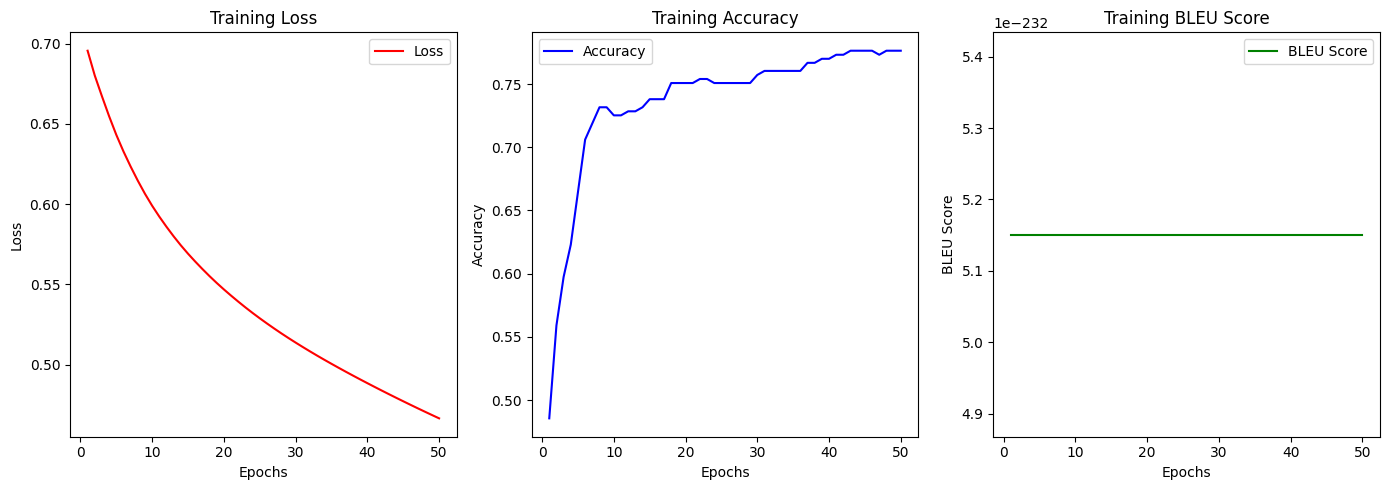

In [ ]:

# Plotting Loss, Accuracy, and BLEU Score
epochs = range(1, len(loss_history) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss_history, 'r-', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy_history, 'b-', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, bleu_scores, 'g-', label='BLEU Score')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training BLEU Score')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

In [78]:

# Evaluate classifier
def evaluate_model(model, test_data, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(test_data, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(test_labels, predicted.numpy())
        precision = precision_score(test_labels, predicted.numpy(), average='weighted')
        f1 = f1_score(test_labels, predicted.numpy(), average='weighted')
        # Calculate BLEU score
        references = [[str(label)] for label in test_labels]
        candidates = [str(pred) for pred in predicted.numpy()]
        bleu_score = sentence_bleu(references, candidates)
        # Confusion Matrix
        conf_matrix = confusion_matrix(test_labels, predicted.numpy())
    return accuracy, precision, f1, bleu_score, conf_matrix

# Evaluate classifier
test_accuracy, test_precision, test_f1, test_bleu, conf_matrix = evaluate_model(classifier, test_embeddings, test_labels)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test F1 Score: {test_f1:.4f}, Test BLEU: {test_bleu:.4f}')

Test Accuracy: 0.6203, Test Precision: 0.6478, Test F1 Score: 0.6278, Test BLEU: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

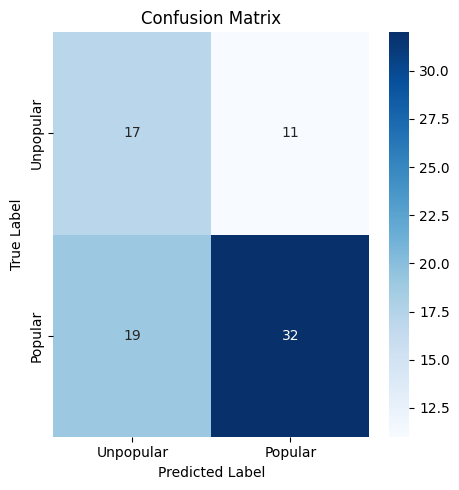

In [79]:
# Plotting Loss, Accuracy, BLEU Score, and Confusion Matrix
epochs = range(1, len(loss_history) + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 4)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Unpopular', 'Popular'], yticklabels=['Unpopular', 'Popular'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()